# 🔬 Single Well Simulation Test

This notebook focuses on simulating **one specific well** to:
- Understand decline curve behavior
- Validate simulation accuracy
- Debug any issues with individual well production

## Contents
1. [Setup & Data Loading](#1.-Setup-&-Data-Loading)
2. [Select a Well](#2.-Select-a-Well)
3. [Analyze Well Production History](#3.-Analyze-Well-Production-History)
4. [Run Single Well Simulation](#4.-Run-Single-Well-Simulation)
5. [Compare Results](#5.-Compare-Results)

---
## 1. Setup & Data Loading

In [1]:
# Standard imports
import sys
import math
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, List, Any, Optional

# Data analysis
import polars as pl
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up paths
SIMULATION_ROOT = Path(r"D:\Mu\Simulation")
DATA_DIR = SIMULATION_ROOT / "data"
sys.path.insert(0, str(SIMULATION_ROOT))

# Configure display
pl.Config.set_tbl_rows(50)
pd.set_option('display.max_columns', 50)

# Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✅ Imports loaded")

✅ Imports loaded


In [2]:
# Load data
print("📊 Loading data...")
fact = pl.read_csv(DATA_DIR / "houston_fact_combined_cleaned.csv")
dim = pl.read_csv(DATA_DIR / "qi_di_b_factor_dimension.csv")

print(f"✅ Fact: {fact.shape[0]:,} rows")
print(f"✅ Dim: {dim.shape[0]:,} rows")

# Add date column
fact = fact.with_columns([
    pl.col('production_vol_date').str.to_date().alias('prod_date')
])

📊 Loading data...
✅ Fact: 2,669,582 rows
✅ Dim: 17,209 rows


In [3]:
# Import simulation modules
try:
    from simulation import SimulationRunner, BasinModel, WellAgent
    from config.simulation_config import (
        WellType, DeclineType, DriveMechanism, WellConfiguration,
        WELL_TYPE_PARAMETERS, CONSTANTS,
    )
    print("✅ Simulation modules loaded!")
except ImportError as e:
    print(f"❌ Import error: {e}")

✅ Simulation modules loaded!


---
## 2. Select a Well

Choose a specific well to simulate. Options:
- Pick a high-producing well for clear trends
- Pick a specific API number you're interested in

In [4]:
# Get summary of all wells
well_summary = (
    fact
    .group_by('api')
    .agg([
        pl.col('prod_date').min().alias('first_date'),
        pl.col('prod_date').max().alias('last_date'),
        pl.col('bopd').max().alias('max_bopd'),
        pl.col('bopd').mean().alias('avg_bopd'),
        pl.col('bopd').sum().alias('total_oil'),
        pl.col('play_type').first().alias('play_type'),
        pl.col('basin').first().alias('basin'),
        pl.col('production_status').last().alias('status'),
        pl.len().alias('days_of_data'),
    ])
    .sort('total_oil', descending=True)
)

print(f"📊 Total wells available: {well_summary.shape[0]:,}")
print("\n🔝 Top 20 wells by total production:")
well_summary.head(20)

📊 Total wells available: 1,563

🔝 Top 20 wells by total production:


shape: (20, 10)
┌────────────┬────────────┬────────────┬────────────┬───┬────────────┬───────┬────────┬────────────┐
│ api        ┆ first_date ┆ last_date  ┆ max_bopd   ┆ … ┆ play_type  ┆ basin ┆ status ┆ days_of_da │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---   ┆ ---    ┆ ta         │
│ i64        ┆ date       ┆ date       ┆ f64        ┆   ┆ str        ┆ str   ┆ str    ┆ ---        │
│            ┆            ┆            ┆            ┆   ┆            ┆       ┆        ┆ u32        │
╞════════════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════╪════════╪════════════╡
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-30 ┆ 828.233333 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0002       ┆            ┆            ┆            ┆   ┆ AL         ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆ OFFSHORE   ┆ BASIN ┆        ┆            │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-30 ┆ 1128.73333 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1310       │
│ 0200       ┆            ┆            ┆ 3          ┆   ┆ AL         ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆ OFFSHORE   ┆ BASIN ┆        ┆            │
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-31 ┆ 968.233333 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1370       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203933304 ┆ 2020-01-01 ┆ 2025-09-30 ┆ 442.241379 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2100       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4220132986 ┆ 2021-05-01 ┆ 2025-03-31 ┆ 1095.03333 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1431       │
│ 0000       ┆            ┆            ┆ 3          ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4270640476 ┆ 2022-04-01 ┆ 2025-09-30 ┆ 719.032258 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 1279       │
│ 0600       ┆            ┆            ┆            ┆   ┆ AL         ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆ OFFSHORE   ┆ BASIN ┆        ┆            │
│ 4203933080 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 207.4      ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901118 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 256.551724 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901084 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 182.064516 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901060 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 187.107143 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901119 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 183.133333 ┆ … ┆ CONVENTION ┆ GULF  ┆ ACTIVE ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ AL ONSHORE ┆ COAST ┆        ┆            │
│            ┆            ┆            ┆            ┆   ┆            ┆ BASIN ┆        ┆            │
│ 4203901075 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 179.

In [5]:
# ========================================================
# 🎯 SELECT YOUR WELL HERE
# ========================================================
# Option 1: Use the top producer
SELECTED_API = well_summary.row(0, named=True)['api']

# Option 2: Specify a specific API number
# SELECTED_API = 42015000750000  # Uncomment and change to your API

# Get well info
well_info = well_summary.filter(pl.col('api') == SELECTED_API).row(0, named=True)

print(f"\n🎯 SELECTED WELL:")
print("=" * 60)
print(f"  API Number:     {SELECTED_API}")
print(f"  Well Type:      {well_info['play_type']}")
print(f"  Basin:          {well_info['basin']}")
print(f"  Status:         {well_info['status']}")
print(f"  Date Range:     {well_info['first_date']} to {well_info['last_date']}")
print(f"  Days of Data:   {well_info['days_of_data']:,}")
print(f"  Max Production: {well_info['max_bopd']:.1f} bopd")
print(f"  Avg Production: {well_info['avg_bopd']:.1f} bopd")
print(f"  Total Oil:      {well_info['total_oil']:,.0f} bbl")


🎯 SELECTED WELL:
  API Number:     42706404270002
  Well Type:      CONVENTIONAL OFFSHORE
  Basin:          GULF COAST BASIN
  Status:         ACTIVE
  Date Range:     2020-01-01 to 2025-09-30
  Days of Data:   2,008
  Max Production: 828.2 bopd
  Avg Production: 385.4 bopd
  Total Oil:      773,936 bbl


---
## 3. Analyze Well Production History

In [6]:
# Get all production data for selected well
well_production = (
    fact
    .filter(pl.col('api') == SELECTED_API)
    .sort('prod_date')
)

print(f"📊 Production records for API {SELECTED_API}:")
print(f"   Total records: {well_production.shape[0]}")
print(f"\n📋 First 10 production records:")
well_production.head(10)

📊 Production records for API 42706404270002:
   Total records: 2008

📋 First 10 production records:


shape: (10, 15)
┌────────────┬────────────┬───────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Unnamed: 0 ┆ api        ┆ basin ┆ play_type  ┆ … ┆ market_id ┆ well_type ┆ basin_nam ┆ prod_date │
│ ---        ┆ ---        ┆ ---   ┆ ---        ┆   ┆ ---       ┆ ---       ┆ e         ┆ ---       │
│ i64        ┆ i64        ┆ str   ┆ str        ┆   ┆ str       ┆ str       ┆ ---       ┆ date      │
│            ┆            ┆       ┆            ┆   ┆           ┆           ┆ str       ┆           │
╞════════════╪════════════╪═══════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2970035    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 1         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970036    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 2         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970037    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 3         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970038    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 4         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970039    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 5         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970040    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 6         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970041    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 7         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970042    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 8         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970043    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 9         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970044    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-1 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 0         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
└────────────┴────────────┴───────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

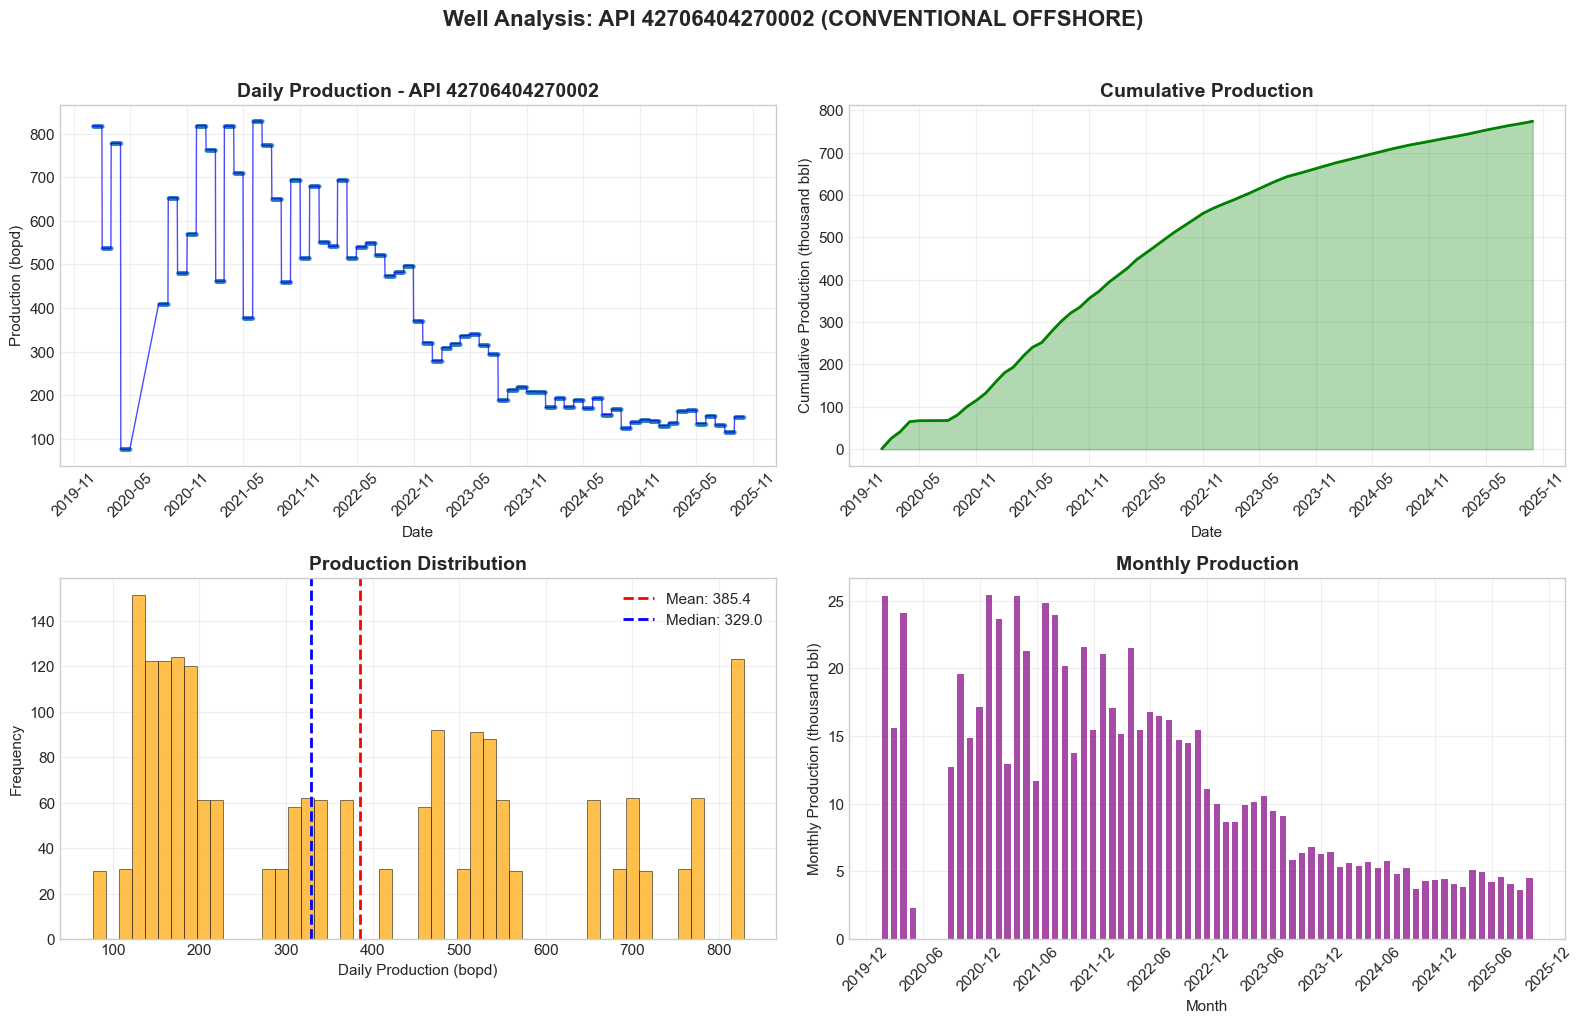


📊 Production Statistics:
   Min:    76.6 bopd
   Max:    828.2 bopd
   Mean:   385.4 bopd
   Median: 329.0 bopd
   Std:    228.1 bopd
   Total:  773,936 bbl


In [8]:
# Plot production history
prod_df = well_production.to_pandas()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Daily production over time
ax1 = axes[0, 0]
ax1.plot(prod_df['prod_date'], prod_df['bopd'], 'b-', linewidth=1, alpha=0.7)
ax1.scatter(prod_df['prod_date'], prod_df['bopd'], s=5, alpha=0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Production (bopd)')
ax1.set_title(f'Daily Production - API {SELECTED_API}', fontsize=14, fontweight='bold')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Cumulative production
ax2 = axes[0, 1]
prod_df['cumulative'] = prod_df['bopd'].cumsum()
ax2.fill_between(prod_df['prod_date'], prod_df['cumulative'] / 1000, alpha=0.3, color='green')
ax2.plot(prod_df['prod_date'], prod_df['cumulative'] / 1000, 'g-', linewidth=2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Production (thousand bbl)')
ax2.set_title('Cumulative Production', fontsize=14, fontweight='bold')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Production distribution
ax3 = axes[1, 0]
ax3.hist(prod_df['bopd'], bins=50, color='orange', alpha=0.7, edgecolor='black', linewidth=0.5)
ax3.axvline(prod_df['bopd'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {prod_df['bopd'].mean():.1f}")
ax3.axvline(prod_df['bopd'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median: {prod_df['bopd'].median():.1f}")
ax3.set_xlabel('Daily Production (bopd)')
ax3.set_ylabel('Frequency')
ax3.set_title('Production Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Monthly production
ax4 = axes[1, 1]
monthly = prod_df.set_index('prod_date')['bopd'].resample('ME').sum()
ax4.bar(monthly.index, monthly.values / 1000, width=20, color='purple', alpha=0.7)
ax4.set_xlabel('Month')
ax4.set_ylabel('Monthly Production (thousand bbl)')
ax4.set_title('Monthly Production', fontsize=14, fontweight='bold')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Well Analysis: API {SELECTED_API} ({well_info["play_type"]})', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print statistics
print(f"\n📊 Production Statistics:")
print(f"   Min:    {prod_df['bopd'].min():.1f} bopd")
print(f"   Max:    {prod_df['bopd'].max():.1f} bopd")
print(f"   Mean:   {prod_df['bopd'].mean():.1f} bopd")
print(f"   Median: {prod_df['bopd'].median():.1f} bopd")
print(f"   Std:    {prod_df['bopd'].std():.1f} bopd")
print(f"   Total:  {prod_df['bopd'].sum():,.0f} bbl")

In [9]:
# Get decline parameters from dimension table for this well type
well_type_upper = well_info['play_type'].upper()

dim_params = (
    dim
    .filter(
        (pl.col('well_type') == well_type_upper) &
        (pl.col('model') == 'hyperbolic')
    )
)

print(f"📊 Decline parameters for {well_type_upper} (Hyperbolic):")
if dim_params.shape[0] > 0:
    avg_qi = dim_params['Qi'].mean()
    avg_di = dim_params['Di'].mean()
    avg_b = dim_params['b_factor'].mean()
    print(f"   Avg Qi: {avg_qi:.1f} bopd")
    print(f"   Avg Di: {avg_di:.4f} (annual decline rate)")
    print(f"   Avg b:  {avg_b:.2f}")
    dim_params.head(10)
else:
    print("   No matching parameters found in dimension table")
    avg_qi = well_info['max_bopd']
    avg_di = 0.3
    avg_b = 0.5

📊 Decline parameters for CONVENTIONAL OFFSHORE (Hyperbolic):
   Avg Qi: 63470.9 bopd
   Avg Di: 0.3887 (annual decline rate)
   Avg b:  0.35


---
## 4. Run Single Well Simulation

In [10]:
# Map play type to simulation well type
def map_play_type(play_type: str) -> str:
    mapping = {
        'CONVENTIONAL ONSHORE': 'Conventional Onshore',
        'CONVENTIONAL OFFSHORE': 'Conventional Offshore',
        'SHALE': 'Shale Oil',
        'TIGHT': 'Tight',
        'CONVENTIONAL TIGHT': 'Conventional Tight',
    }
    return mapping.get(play_type.upper(), 'Conventional Onshore')

# Prepare well configuration
WELL_CONFIG = {
    'api_number': SELECTED_API,
    'well_type': map_play_type(well_info['play_type']),
    'initial_production': float(well_info['max_bopd']),  # Use max as initial
    'b_factor': float(avg_b) if avg_b else 0.5,
    'nominal_decline_rate': float(avg_di) if avg_di else 0.3,
    'decline_type': 'Hyperbolic',
    'location': well_info['basin'],
    'basin': well_info['basin'],
    'production_start_date': datetime(well_info['first_date'].year, well_info['first_date'].month, well_info['first_date'].day),
}

print("📋 Well Configuration for Simulation:")
print("=" * 60)
for key, value in WELL_CONFIG.items():
    print(f"   {key:25}: {value}")

📋 Well Configuration for Simulation:
   api_number               : 42706404270002
   well_type                : Conventional Offshore
   initial_production       : 828.2333333333332
   b_factor                 : 0.35000000000000026
   nominal_decline_rate     : 0.38866153862616815
   decline_type             : Hyperbolic
   location                 : GULF COAST BASIN
   basin                    : GULF COAST BASIN
   production_start_date    : 2020-01-01 00:00:00


In [11]:
# Define simulation period (match the data range)
SIM_START = WELL_CONFIG['production_start_date']
SIM_END = datetime(well_info['last_date'].year, well_info['last_date'].month, well_info['last_date'].day)

print(f"📅 Simulation Period:")
print(f"   Start: {SIM_START.date()}")
print(f"   End:   {SIM_END.date()}")
print(f"   Days:  {(SIM_END - SIM_START).days}")

📅 Simulation Period:
   Start: 2020-01-01
   End:   2025-09-30
   Days:  2099


In [12]:
# Create simulation runner
try:
    runner = SimulationRunner(
        total_recoverable_resources=1_000_000_000,  # Large enough for single well
        start_date=SIM_START,
        end_date=SIM_END,
        basin_name=well_info['basin'],
        market_center='Houston',
        country='US',
    )
    print("✅ SimulationRunner created")
    print(f"   Total steps: {runner.total_steps}")
except Exception as e:
    print(f"❌ Error: {e}")
    runner = None

No reserves data available for market_center='Houston'. Reserves tracking disabled.


✅ SimulationRunner created
   Total steps: 2099


In [13]:
# Add the single well
if runner:
    try:
        well_state = runner.add_well(**WELL_CONFIG)
        print(f"✅ Well added successfully!")
        print(f"   ID: {well_state['id']}")
        print(f"   Type: {well_state['well_type']}")
        print(f"   Initial Production: {well_state['initial_production']:.1f} bopd")
        print(f"   EUR: {well_state['eur']:,.0f} bbl")
    except Exception as e:
        print(f"❌ Error adding well: {e}")

✅ Well added successfully!
   ID: 2
   Type: Conventional Offshore
   Initial Production: 828.2 bopd
   EUR: 1,139,350 bbl


In [14]:
# Run the simulation
if runner:
    print("🚀 Running single well simulation...")
    
    sim_results = []
    runner.start()
    step = 0
    
    while runner.model.simulation_active:
        state = runner.step()
        step += 1
        
        sim_state = state['state']
        wells = sim_state['basin']['wells']
        
        if wells:
            well = wells[0]  # Single well
            sim_results.append({
                'date': sim_state['current_date'],
                'daily_production': well['daily_production'],
                'potential_production': well['daily_potential_production'],
                'cumulative': well['cumulative_production'],
                'days_on_prod': well['days_on_production'],
                'is_active': well['is_active'],
            })
        
        # Progress
        if step % 100 == 0:
            print(f"   Day {step}: {sim_results[-1]['daily_production']:.1f} bopd")
    
    print(f"\n✅ Simulation complete! {step} days")
    
    # Convert to DataFrame
    sim_df = pd.DataFrame(sim_results)
    sim_df['date'] = pd.to_datetime(sim_df['date'])
    sim_df.set_index('date', inplace=True)
    
    print(f"\n📊 Simulation Results:")
    print(f"   Start prod: {sim_df['daily_production'].iloc[0]:.1f} bopd")
    print(f"   End prod:   {sim_df['daily_production'].iloc[-1]:.1f} bopd")
    print(f"   Total:      {sim_df['daily_production'].sum():,.0f} bbl")

🚀 Running single well simulation...

📊 MONTHLY PRODUCTION BY GRADE - January 2020
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):             0.00 bbl
   Light Sweet (lSweet):       25,244.60 bbl
   ────────────────────────────────────────
   TOTAL:                      25,244.60 bbl


📊 MONTHLY PRODUCTION BY GRADE - February 2020
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):             0.00 bbl
   Light Sweet (lSweet):       22,882.06 bbl
   ────────────────────────────────────────
   TOTAL:                      22,882.06 bbl


📊 MONTHLY PRODUCTION BY GRADE - March 2020
   Market Center: Houston
   Heavy Sour  (hSour):      

---
## 5. Compare Results

In [15]:
# Prepare actual production for comparison
actual_df = prod_df.copy()
actual_df['date'] = pd.to_datetime(actual_df['prod_date'])
actual_df = actual_df.set_index('date')[['bopd']]
actual_df.columns = ['actual']

# Merge simulated and actual
comparison = sim_df[['daily_production']].join(actual_df, how='outer')
comparison.columns = ['Simulated', 'Actual']
comparison = comparison.dropna(how='all').fillna(0)

print(f"📊 Comparison data: {len(comparison)} days")
comparison.head(20)

📊 Comparison data: 2100 days


Simulated      Actual
date                              
2020-01-01    0.000000  816.709677
2020-01-02  827.352645  816.709677
2020-01-03  826.473221  816.709677
2020-01-04  825.595058  816.709677
2020-01-05  824.718154  816.709677
2020-01-06  823.842507  816.709677
2020-01-07  822.968115  816.709677
2020-01-08  822.094975  816.709677
2020-01-09  821.223085  816.709677
2020-01-10  820.352444  816.709677
2020-01-11  819.483047  816.709677
2020-01-12  818.614895  816.709677
2020-01-13  817.747983  816.709677
2020-01-14  816.882310  816.709677
2020-01-15  816.017874  816.709677
2020-01-16  815.154673  816.709677
2020-01-17  814.292704  816.709677
2020-01-18  813.431964  816.709677
2020-01-19  812.572453  816.709677
2020-01-20  811.714167  816.709677

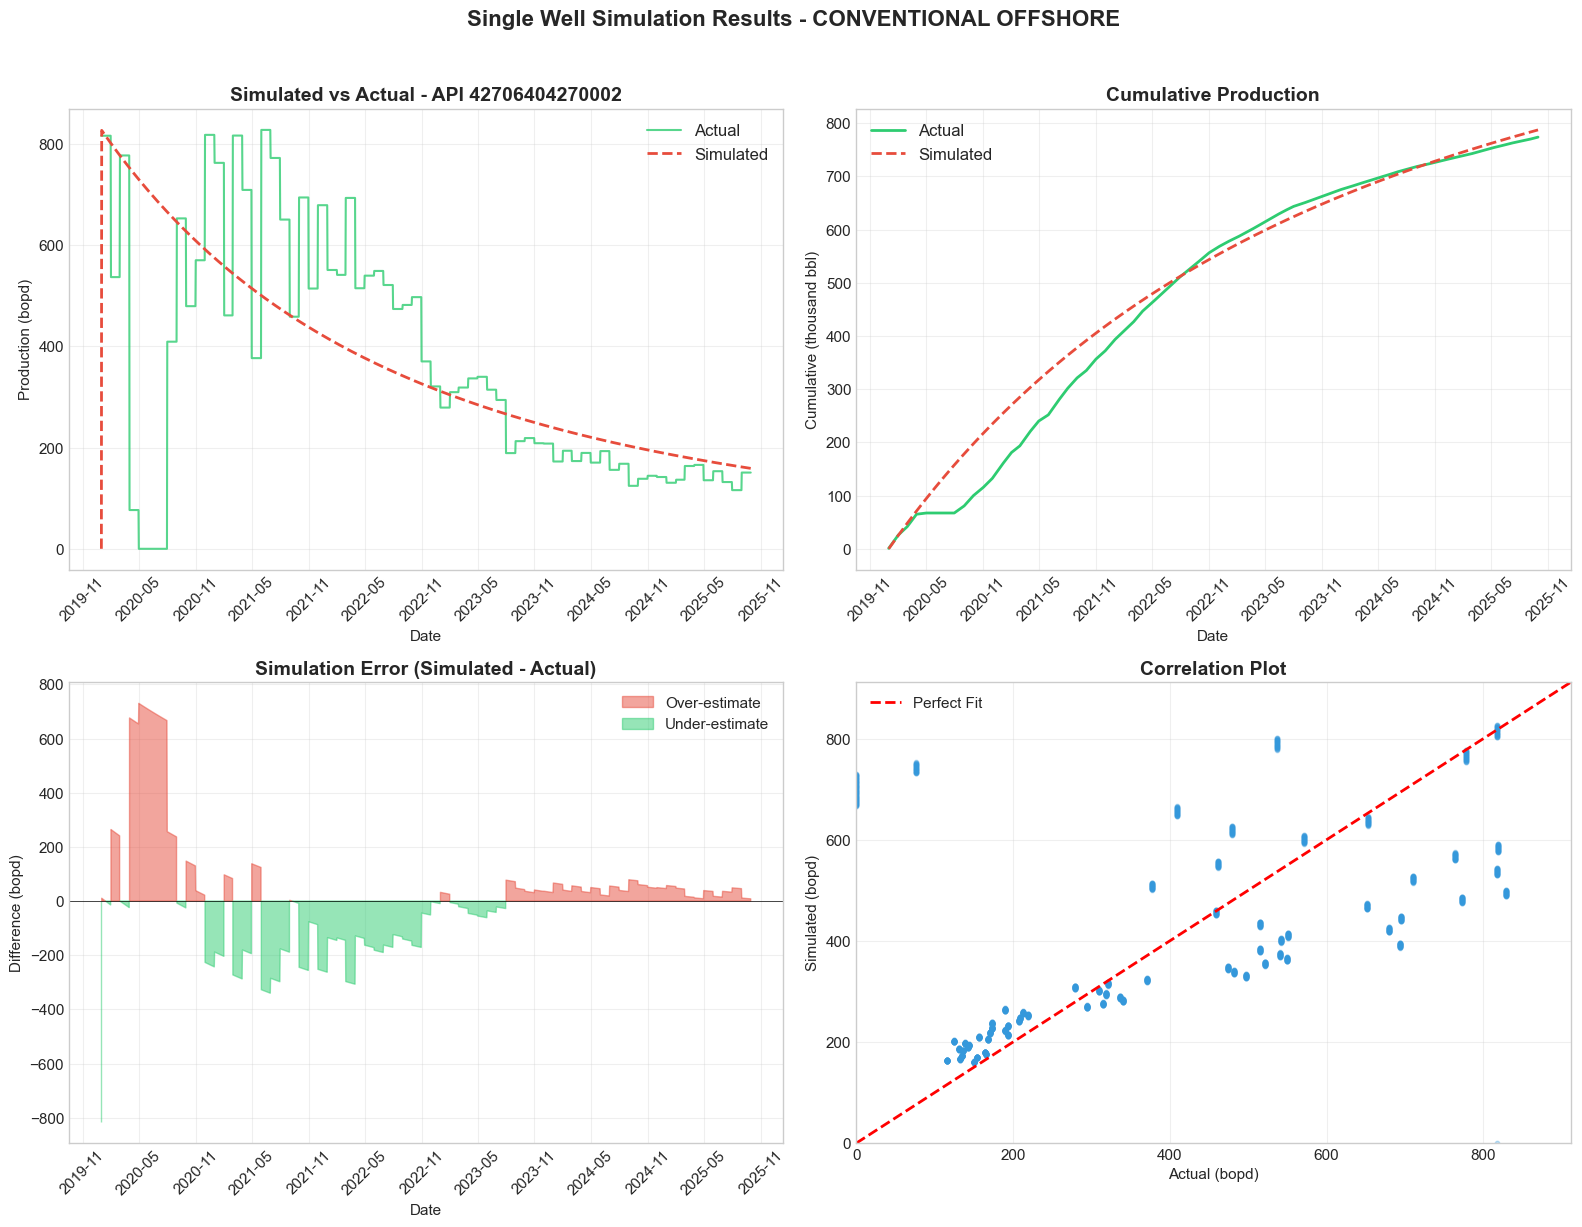

In [16]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Daily production comparison
ax1 = axes[0, 0]
ax1.plot(comparison.index, comparison['Actual'], label='Actual', 
         color='#2ecc71', linewidth=1.5, alpha=0.8)
ax1.plot(comparison.index, comparison['Simulated'], label='Simulated', 
         color='#e74c3c', linewidth=2, linestyle='--')
ax1.set_xlabel('Date')
ax1.set_ylabel('Production (bopd)')
ax1.set_title(f'Simulated vs Actual - API {SELECTED_API}', fontsize=14, fontweight='bold')
ax1.legend(fontsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Cumulative comparison
ax2 = axes[0, 1]
sim_cum = comparison['Simulated'].cumsum()
actual_cum = comparison['Actual'].cumsum()
ax2.plot(comparison.index, actual_cum / 1000, label='Actual', color='#2ecc71', linewidth=2)
ax2.plot(comparison.index, sim_cum / 1000, label='Simulated', color='#e74c3c', linewidth=2, linestyle='--')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative (thousand bbl)')
ax2.set_title('Cumulative Production', fontsize=14, fontweight='bold')
ax2.legend(fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Error
ax3 = axes[1, 0]
error = comparison['Simulated'] - comparison['Actual']
ax3.fill_between(comparison.index, error, where=error >= 0, color='#e74c3c', alpha=0.5, label='Over-estimate')
ax3.fill_between(comparison.index, error, where=error < 0, color='#2ecc71', alpha=0.5, label='Under-estimate')
ax3.axhline(0, color='black', linewidth=0.5)
ax3.set_xlabel('Date')
ax3.set_ylabel('Difference (bopd)')
ax3.set_title('Simulation Error (Simulated - Actual)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Scatter correlation
ax4 = axes[1, 1]
ax4.scatter(comparison['Actual'], comparison['Simulated'], alpha=0.3, s=10, c='#3498db')
max_val = max(comparison['Actual'].max(), comparison['Simulated'].max()) * 1.1
ax4.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Fit')
ax4.set_xlabel('Actual (bopd)')
ax4.set_ylabel('Simulated (bopd)')
ax4.set_title('Correlation Plot', fontsize=14, fontweight='bold')
ax4.set_xlim(0, max_val)
ax4.set_ylim(0, max_val)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Single Well Simulation Results - {well_info["play_type"]}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [17]:
# Print comparison statistics
print("\n📊 COMPARISON STATISTICS:")
print("=" * 60)
print(f"\n🔵 ACTUAL Production:")
print(f"   Total:      {comparison['Actual'].sum():,.0f} bbl")
print(f"   Average:    {comparison['Actual'].mean():.1f} bopd")
print(f"   Max:        {comparison['Actual'].max():.1f} bopd")
print(f"   Start:      {comparison['Actual'].iloc[0]:.1f} bopd")
print(f"   End:        {comparison['Actual'].iloc[-1]:.1f} bopd")

print(f"\n🔴 SIMULATED Production:")
print(f"   Total:      {comparison['Simulated'].sum():,.0f} bbl")
print(f"   Average:    {comparison['Simulated'].mean():.1f} bopd")
print(f"   Max:        {comparison['Simulated'].max():.1f} bopd")
print(f"   Start:      {comparison['Simulated'].iloc[0]:.1f} bopd")
print(f"   End:        {comparison['Simulated'].iloc[-1]:.1f} bopd")

print(f"\n📏 ERROR METRICS:")
total_error = comparison['Simulated'].sum() - comparison['Actual'].sum()
pct_error = total_error / comparison['Actual'].sum() * 100 if comparison['Actual'].sum() > 0 else 0
print(f"   Total Error:  {total_error:,.0f} bbl ({pct_error:+.1f}%)")

# MAPE
mask = comparison['Actual'] > 0
if mask.sum() > 0:
    mape = (abs(comparison['Simulated'][mask] - comparison['Actual'][mask]) / comparison['Actual'][mask]).mean() * 100
    print(f"   MAPE:         {mape:.1f}%")

# Correlation
corr = comparison['Simulated'].corr(comparison['Actual'])
print(f"   Correlation:  {corr:.4f}")

# RMSE
rmse = np.sqrt(((comparison['Simulated'] - comparison['Actual']) ** 2).mean())
print(f"   RMSE:         {rmse:.1f} bopd")


📊 COMPARISON STATISTICS:

🔵 ACTUAL Production:
   Total:      773,936 bbl
   Average:    368.5 bopd
   Max:        828.2 bopd
   Start:      816.7 bopd
   End:        150.7 bopd

🔴 SIMULATED Production:
   Total:      787,475 bbl
   Average:    375.0 bopd
   Max:        827.4 bopd
   Start:      0.0 bopd
   End:        159.0 bopd

📏 ERROR METRICS:
   Total Error:  13,539 bbl (+1.7%)
   MAPE:         37.3%
   Correlation:  0.5216
   RMSE:         210.2 bopd


In [19]:
# Monthly comparison
monthly_sim = comparison['Simulated'].resample('ME').sum()
monthly_actual = comparison['Actual'].resample('ME').sum()

monthly_compare = pd.DataFrame({
    'Simulated': monthly_sim / 1000,
    'Actual': monthly_actual / 1000,
    'Error': (monthly_sim - monthly_actual) / 1000,
    'Error_Pct': ((monthly_sim - monthly_actual) / monthly_actual * 100).replace([np.inf, -np.inf], 0)
})

print("\n📊 Monthly Comparison (thousand bbl):")
monthly_compare


📊 Monthly Comparison (thousand bbl):


Simulated  Actual      Error   Error_Pct
date                                                
2020-01-31  24.443090  25.318  -0.874910   -3.455685
2020-02-29  22.906018  15.579   7.327018   47.031376
2020-03-31  23.733124  24.110  -0.376876   -1.563154
2020-04-30  22.257458   2.299  19.958458  868.136490
2020-05-31  22.296078   0.000  22.296078    0.000000
...               ...     ...        ...         ...
2025-05-31   5.356466   4.202   1.154466   27.474209
2025-06-30   5.087681   4.603   0.484681   10.529666
2025-07-31   5.160551   4.092   1.068551   26.113164
2025-08-31   5.064685   3.596   1.468685   40.842178
2025-09-30   4.812281   4.522   0.290281    6.419308

[69 rows x 4 columns]

In [ ]:
# Experiment with different parameters
print("\n🔧 PARAMETER SENSITIVITY TEST")
print("=" * 60)
print(f"Current parameters:")
print(f"   Qi = {WELL_CONFIG['initial_production']:.1f} bopd")
print(f"   Di = {WELL_CONFIG['nominal_decline_rate']:.4f}")
print(f"   b  = {WELL_CONFIG['b_factor']:.2f}")
print(f"\nTo tune the model, try adjusting:")
print(f"   - Increase b: Slower decline (harmonic-like)")
print(f"   - Decrease b: Faster decline (exponential-like)")
print(f"   - Increase Di: Steeper initial decline")
print(f"   - Decrease Di: Slower decline rate")

---
## 📝 Summary

This notebook tested a single well simulation for validation purposes.

### Key Findings:
- See the comparison statistics above for accuracy metrics
- The decline curve parameters (Qi, Di, b) can be tuned for better fit
- Real production often has variability not captured by smooth decline curves

### Next Steps:
1. Try different b-factor values to improve fit
2. Consider using well-specific parameters instead of averages
3. Test wells from different play types